# Energy Volume Curve
While the total energies calculated with DFT are not very useful, the energy differences calculated from these total energies can be applied to calculate a number of material properties. One common example is the calculation of the bulk modulus as the second derivative of the change of energy with volume. 

Following the first two tutorials the [SPHInX](https://sxrepo.mpie.de) DFT code is used in combination with [pyiron.org](https://pyiron.org) workflow framework. The installation of these software packages is explained in the first tutorial. In analogy to the first two tutorials, also the third tutorial starts by importing the `Project` object in addition to `matplotlib` and `numpy`. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyiron_atomistics import Project

## Calculation
In addition, to interfaces to different simulation codes pyiron also includes `GenericMaster` jobs which run multiple individual calculation in one job. This is similar to the for-loops used in the previous tutorial. For calculating the energy volume curve users can either write their own for-loop or alternatively they can use the `Murnaghan` job type. Especially when nesting multiple for-loops these `GenericMaster` jobs can simplify the workflow. 

A new `Project` object is created named `murn_conv` to separate the calculation from the current tutorial and the previous. Any remaining calculation in the `murn_conv` folder are removed using the `remove_jobs()` function, to provide a fresh start for every execution of the notebook.

In [2]:
pr = Project("murn_conv")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

Based on a previous iteraction of this tutorial, it is recommended to adjust the lattice constant for Aluminium from the experimental suggestion of `a=4.04` to `a=4.09`. This can depend on the choice of pseudo potential resulting in an overall difference between the prediction from DFT and the measurements from experiment. 

In [3]:
structure_Al = pr.create.structure.ase.bulk("Al", a=4.09)

From the study of the energy convergence in dependence of the planewave energy cut-off the range of planewave energy cut-offs is adopted while reducing the sampling density to five steps between the low planewave energy cut-off at 200eV and the high planewave energy cut-off at 600eV.

In [4]:
encut_lst = np.linspace(200, 600, 5)
encut_lst

array([200., 300., 400., 500., 600.])

The outer loop again iterates over the list of planewave energy cutoffs while the internal loop over the different volumes is handled by the `Murnaghan` job class. In this way no additional loop is required. Once more this highlights the scalability of the `pyiron` workflow framework. 

For the k-point mesh again a rather small mesh of $2\times2\times2$ is chosen in order to optimize for computational efficiency rather than DFT precision. At the end of each energy volume curve computation the list of volumes, energies as well as the equilibrium volume and equilibrium bulk modulus are stored in corresponding lists.

In [5]:
volume_lst, energy_lst, v0_lst, b0_lst = [], [], [], []
for encut in encut_lst:
    job_Al = pr.create.job.Sphinx("spx")
    job_Al.structure = structure_Al
    job_Al.set_kpoints([2,2,2])
    job_Al.set_encut(encut)
    job_Al.server.cores = 1
    murn = pr.create.job.Murnaghan("murn_encut_{:.0f}".format(encut))
    murn.ref_job = job_Al
    murn.run()
    volume_lst.append(murn.content["output/volume"])
    energy_lst.append(murn.content["output/energy"])
    v0_lst.append(murn.content["output/equilibrium_volume"])
    b0_lst.append(murn.content["output/equilibrium_bulk_modulus"])

The job murn_encut_200 was saved and received the ID: 38
The job murn_encut_200_0_9 was saved and received the ID: 39
The job murn_encut_200_0_92 was saved and received the ID: 40
The job murn_encut_200_0_94 was saved and received the ID: 41
The job murn_encut_200_0_96 was saved and received the ID: 42
The job murn_encut_200_0_98 was saved and received the ID: 43
The job murn_encut_200_1_0 was saved and received the ID: 44
The job murn_encut_200_1_02 was saved and received the ID: 45
The job murn_encut_200_1_04 was saved and received the ID: 46
The job murn_encut_200_1_06 was saved and received the ID: 47
The job murn_encut_200_1_08 was saved and received the ID: 48
The job murn_encut_200_1_1 was saved and received the ID: 49
The job murn_encut_300 was saved and received the ID: 50
The job murn_encut_300_0_9 was saved and received the ID: 51
The job murn_encut_300_0_92 was saved and received the ID: 52
The job murn_encut_300_0_94 was saved and received the ID: 53
The job murn_encut_300

## Analysis 
As a first step the convergence of the equilibrium volume and the equilibrium bulk modulus can be plotted over the list of planewave energy cut-offs. This follows the same representation as previously in the second tutorial for the energy convergence. 

Text(0, 0.5, 'Equilibrium Volume ($\\AA^3$)')

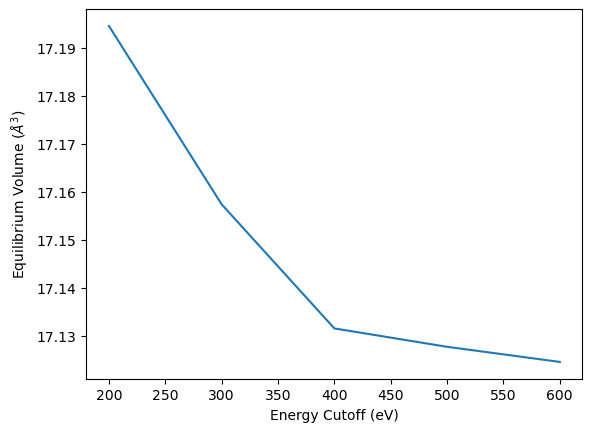

In [6]:
plt.plot(encut_lst, v0_lst)
plt.xlabel("Energy Cutoff (eV)")
plt.ylabel("Equilibrium Volume ($\AA^3$)")

Text(0, 0.5, 'Equilibrium Bulk Modulus (GPa)')

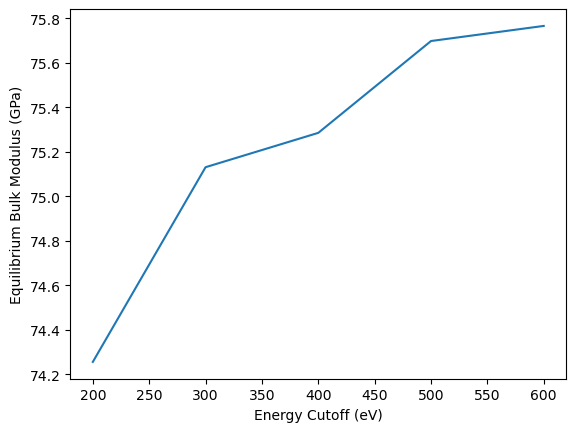

In [7]:
plt.plot(encut_lst, b0_lst)
plt.xlabel("Energy Cutoff (eV)")
plt.ylabel("Equilibrium Bulk Modulus (GPa)")

While the equilibrium Volume decreases with increasing energy cutoff the bulk modulus increases with increasing energy cutoff. From these results the question arises how these results are related to the energy convergence at the different volumes, following the general notion that relative energies in DFT calculation converge faster than total energies. As a first step of this analyis the individual energy volume curves are plotted by fitting the corresponding energy volume curves. 

Text(0, 0.5, 'Energy (eV)')

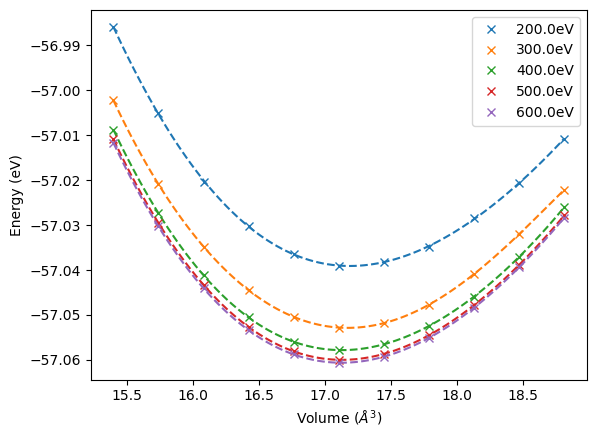

In [8]:
color_ind = 0
for vol, eng, encut in zip(volume_lst, energy_lst, encut_lst):
    plt.plot(vol, eng, "x", label=str(encut) + "eV", color="C" + str(color_ind))
    fit = np.polyfit(vol, eng, 5)
    vol_lst = np.linspace(np.min(vol), np.max(vol), 100)
    plt.plot(vol_lst, np.poly1d(fit)(vol_lst), "--", color="C" + str(color_ind))
    color_ind += 1
plt.legend()
plt.xlabel("Volume ($\AA^3$)")
plt.ylabel("Energy (eV)")

When subtracting the fit from the calculated energy volume pairs we find that the energy is scattered around the fit. The gaussian distribution of the energy is expected based on the choice of least square fit. Still when carefully resolving the difference between to very close volumes jumps can be found related to the jumps from adding new plane waves. Nevertheless these effects are in the order of less than 1meV.

Text(0, 0.5, '$\\Delta$ Energy (meV)')

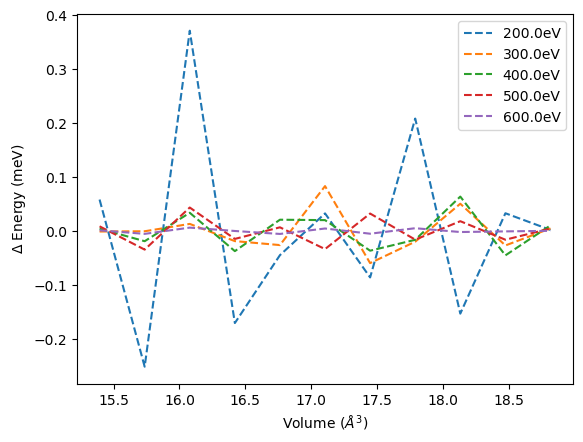

In [9]:
color_ind = 0
for vol, eng, encut in zip(volume_lst, energy_lst, encut_lst):
    fit = np.polyfit(vol, eng, 5)
    plt.plot(vol, (np.poly1d(fit)(vol)-eng) * 1000, "--", label=str(encut) + "eV", color="C" + str(color_ind))
    color_ind += 1
plt.legend()
plt.xlabel("Volume ($\AA^3$)")
plt.ylabel("$\Delta$ Energy (meV)")

## Conclusion
The convergence of total energies alone is insufficient, rather for any property calculated from a DFT calculation a separate convergence test is required. The convergence for the equilibrium bulk modulus and the equilibrium volume are just two examples. 